# Static Importance Index Calculator for Java Methods

This notebook computes static importance indices for Java methods using both **Knowledge Graph** data from Neo4j and **AST** metadata. The goal is to create normalized weights that will be used for method retrieval in a hybrid RAG system for code generation.

## Metrics Computed:
- **Code Complexity**: LOC, Cyclomatic Complexity, Cognitive Complexity, Halstead Effort
- **Graph Centrality**: Degree Centrality, Betweenness Centrality, Eigenvector Centrality
- **Method Dependencies**: Fan-in, Fan-out 
- **Parameter Analysis**: Number of parameters, parameter type complexity, return type complexity

## Data Sources:
- **Neo4j Knowledge Graph**: `http://4.187.169.27:7474/browser/`
- **AST Data**: `../AST/java_parsed.csv`
- **Target Project**: Library Management System

## 1. Setup and Import Libraries

Import all necessary libraries for Neo4j connectivity, data analysis, graph operations, and complexity calculations.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Neo4j connection
from neo4j import GraphDatabase
import logging

# Graph analysis
import networkx as nx

# For complexity calculations
import ast
import math
from typing import Dict, List, Tuple, Set

# For Java AST parsing
try:
    from tree_sitter import Language, Parser
    from tree_sitter_languages import get_language
    TREE_SITTER_AVAILABLE = True
except ImportError:
    print("tree-sitter not available. Some complexity metrics will use simplified calculations.")
    TREE_SITTER_AVAILABLE = False

# Setup plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Tree-sitter available: {TREE_SITTER_AVAILABLE}")

tree-sitter not available. Some complexity metrics will use simplified calculations.
Libraries imported successfully!
Tree-sitter available: False


## 2. Connect to Neo4j Knowledge Graph

Establish connection to the Neo4j database containing the Java knowledge graph and verify connectivity.

In [2]:
# Neo4j connection configuration
NEO4J_URI = "bolt://98.70.123.110:7687"  # Updated to new Neo4j instance
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "y?si+:qDV3DK"  # Updated password

class Neo4jConnection:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
        
    def close(self):
        self.driver.close()
        
    def query(self, query, parameters=None):
        with self.driver.session() as session:
            result = session.run(query, parameters)
            return [record for record in result]

# Initialize connection
neo4j_conn = Neo4jConnection(NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD)

# Test connection and get database info
try:
    # Test basic connectivity
    test_result = neo4j_conn.query("RETURN 'Connection successful' as message")
    print("✅ Neo4j connection successful!")
    print(f"Result: {test_result[0]['message']}")
    
    # Get database statistics
    node_count = neo4j_conn.query("MATCH (n) RETURN count(n) as count")[0]['count']
    rel_count = neo4j_conn.query("MATCH ()-[r]->() RETURN count(r) as count")[0]['count']
    
    print(f"\n📊 Database Statistics:")
    print(f"Total nodes: {node_count:,}")
    print(f"Total relationships: {rel_count:,}")
    
    # Get available node labels
    labels_result = neo4j_conn.query("CALL db.labels()")
    labels = [record['label'] for record in labels_result]
    print(f"Available node labels: {labels}")
    
    # Get available relationship types
    rel_types_result = neo4j_conn.query("CALL db.relationshipTypes()")
    rel_types = [record['relationshipType'] for record in rel_types_result]
    print(f"Available relationship types: {rel_types}")
    
    # Specifically check for CALLS and CALLED_BY relationships
    calls_count = neo4j_conn.query("MATCH ()-[r:CALLS]->() RETURN count(r) as count")[0]['count']
    called_by_count = neo4j_conn.query("MATCH ()-[r:CALLED_BY]->() RETURN count(r) as count")[0]['count']
    print(f"\n🔍 Call Relationship Analysis:")
    print(f"CALLS relationships: {calls_count:,}")
    print(f"CALLED_BY relationships: {called_by_count:,}")
    
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("Please check the Neo4j server status and credentials.")

✅ Neo4j connection successful!
Result: Connection successful

📊 Database Statistics:
Total nodes: 1,122
Total relationships: 2,209
Available node labels: ['Import', 'Package', 'Class', 'Field', 'Variable', 'Constructor', 'Parameter', 'Method', 'Type', 'Annotation', 'Interface', 'Enum']
Available relationship types: ['HAS_FIELD', 'HAS_CONSTRUCTOR', 'HAS_PARAMETER', 'HAS_METHOD', 'RETURNS', 'CALLS', 'USES', 'INHERITS', 'HAS_ANNOTATION', 'CALLED_BY', 'BELONGS_TO', 'IMPLEMENTS']

🔍 Call Relationship Analysis:
CALLS relationships: 372
CALLED_BY relationships: 372
Available relationship types: ['HAS_FIELD', 'HAS_CONSTRUCTOR', 'HAS_PARAMETER', 'HAS_METHOD', 'RETURNS', 'CALLS', 'USES', 'INHERITS', 'HAS_ANNOTATION', 'CALLED_BY', 'BELONGS_TO', 'IMPLEMENTS']

🔍 Call Relationship Analysis:
CALLS relationships: 372
CALLED_BY relationships: 372


## 3. Load AST Data from CSV

Load the existing AST parsed data and perform initial exploration.

In [3]:
# Load AST data from CSV
ast_file_path = "../AST/java_parsed.csv"

try:
    ast_df = pd.read_csv(ast_file_path)
    print(f"✅ Successfully loaded AST data: {len(ast_df)} methods found")
    
    # Basic data exploration
    print(f"\n📊 AST Data Overview:")
    print(f"Shape: {ast_df.shape}")
    print(f"Columns: {list(ast_df.columns)}")
    
    # Display sample data
    print(f"\n🔍 Sample Data:")
    print(ast_df.head())
    
    # Check for missing values
    print(f"\n❓ Missing Values:")
    missing_counts = ast_df.isnull().sum()
    print(missing_counts[missing_counts > 0])
    
    # Basic statistics
    print(f"\n📈 Basic Statistics:")
    print(f"Unique classes: {ast_df['Class'].nunique()}")
    print(f"Unique packages: {ast_df['Package'].nunique()}")
    print(f"Methods with function body: {ast_df['Function Body'].notna().sum()}")
    
    # Method distribution by class
    method_counts = ast_df['Class'].value_counts()
    print(f"\n🏗️ Top 10 Classes by Method Count:")
    print(method_counts.head(10))
    
except FileNotFoundError:
    print(f"❌ Could not find AST file at: {ast_file_path}")
    print("Please ensure the AST parsing has been completed and the file exists.")
except Exception as e:
    print(f"❌ Error loading AST data: {e}")

✅ Successfully loaded AST data: 264 methods found

📊 AST Data Overview:
Shape: (264, 10)
Columns: ['FilePath', 'Package', 'Class', 'Method Name', 'Return Type', 'Parameters', 'Function Body', 'Throws', 'Modifiers', 'Generics']

🔍 Sample Data:
                                            FilePath  Package       Class  \
0  C:\Users\divchauhan\Downloads\Library-Assistan...      NaN  AlertMaker   
1  C:\Users\divchauhan\Downloads\Library-Assistan...      NaN  AlertMaker   
2  C:\Users\divchauhan\Downloads\Library-Assistan...      NaN  AlertMaker   
3  C:\Users\divchauhan\Downloads\Library-Assistan...      NaN  AlertMaker   
4  C:\Users\divchauhan\Downloads\Library-Assistan...      NaN  AlertMaker   

          Method Name Return Type  \
0     showSimpleAlert        void   
1    showErrorMessage        void   
2    showErrorMessage        void   
3    showErrorMessage        void   
4  showMaterialDialog        void   

                                          Parameters  \
0              

## 4. Extract Method Information from Knowledge Graph

Query the Neo4j graph to extract method nodes and their relationships.

In [4]:
# Extract method information from Knowledge Graph
def extract_kg_data():
    """Extract all relevant data from the knowledge graph, focusing on CALLS and CALLED_BY relationships"""
    
    # Get all method nodes
    methods_query = """
    MATCH (m:Method)
    RETURN m.name as method_name, 
           id(m) as node_id,
           m.depth as depth,
           labels(m) as labels
    """
    
    # Get CALLS and CALLED_BY relationships specifically
    calls_relationships_query = """
    MATCH (m1:Method)-[r:CALLS]->(m2:Method)
    RETURN m1.name as source_method,
           m2.name as target_method,
           'CALLS' as relationship_type,
           id(m1) as source_id,
           id(m2) as target_id
    UNION ALL
    MATCH (m1:Method)-[r:CALLED_BY]->(m2:Method)
    RETURN m1.name as source_method,
           m2.name as target_method,
           'CALLED_BY' as relationship_type,
           id(m1) as source_id,
           id(m2) as target_id
    """
    
    # Get method-class relationships
    method_class_query = """
    MATCH (c:Class)-[r:HAS_METHOD]->(m:Method)
    RETURN c.name as class_name,
           m.name as method_name,
           id(c) as class_id,
           id(m) as method_id
    UNION ALL
    MATCH (m:Method)-[r:BELONGS_TO]->(c:Class)
    RETURN c.name as class_name,
           m.name as method_name,
           id(c) as class_id,
           id(m) as method_id
    """
    
    # Get method parameters
    method_params_query = """
    MATCH (m:Method)-[r:HAS_PARAMETER]->(p)
    RETURN m.name as method_name,
           p.name as param_name,
           id(m) as method_id,
           id(p) as param_id
    """
    
    try:
        print("🔄 Extracting method nodes...")
        methods_data = neo4j_conn.query(methods_query)
        methods_df = pd.DataFrame([dict(record) for record in methods_data])
        print(f"Found {len(methods_df)} method nodes")
        
        print("🔄 Extracting CALLS and CALLED_BY relationships...")
        relationships_data = neo4j_conn.query(calls_relationships_query)
        relationships_df = pd.DataFrame([dict(record) for record in relationships_data])
        print(f"Found {len(relationships_df)} call relationships")
        
        # Analyze the distribution of relationship types
        if not relationships_df.empty:
            rel_distribution = relationships_df['relationship_type'].value_counts()
            print(f"📊 Relationship type distribution:")
            for rel_type, count in rel_distribution.items():
                print(f"  {rel_type}: {count}")
        
        print("🔄 Extracting method-class relationships...")
        method_class_data = neo4j_conn.query(method_class_query)
        method_class_df = pd.DataFrame([dict(record) for record in method_class_data])
        print(f"Found {len(method_class_df)} method-class relationships")
        
        print("🔄 Extracting method parameters...")
        method_params_data = neo4j_conn.query(method_params_query)
        method_params_df = pd.DataFrame([dict(record) for record in method_params_data])
        print(f"Found {len(method_params_df)} method parameters")
        
        # Additional analysis of the call graph structure
        if not relationships_df.empty:
            unique_callers = relationships_df['source_method'].nunique()
            unique_callees = relationships_df['target_method'].nunique()
            print(f"\n🔍 Call Graph Analysis:")
            print(f"Unique calling methods: {unique_callers}")
            print(f"Unique called methods: {unique_callees}")
            
            # Show sample relationships
            print(f"\n📋 Sample call relationships:")
            sample_rels = relationships_df.head(10)
            for _, row in sample_rels.iterrows():
                print(f"  {row['source_method']} -{row['relationship_type']}-> {row['target_method']}")
        
        return {
            'methods': methods_df,
            'relationships': relationships_df,
            'method_class': method_class_df,
            'method_params': method_params_df
        }
        
    except Exception as e:
        print(f"❌ Error extracting KG data: {e}")
        return None

# Extract the data
kg_data = extract_kg_data()

if kg_data:
    print("\n✅ Knowledge Graph data extracted successfully!")
    
    # Display sample data
    for key, df in kg_data.items():
        print(f"\n📊 {key.upper()} Sample:")
        if not df.empty:
            print(df.head())
            print(f"Shape: {df.shape}")
        else:
            print("No data found")
else:
    print("❌ Failed to extract knowledge graph data")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 4, column: 12, offset: 68} for query: '\n    MATCH (m:Method)\n    RETURN m.name as method_name, \n           id(m) as node_id,\n           m.depth as depth,\n           labels(m) as labels\n    '


🔄 Extracting method nodes...
Found 280 method nodes
🔄 Extracting CALLS and CALLED_BY relationships...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 6, column: 12, offset: 172} for query: "\n    MATCH (m1:Method)-[r:CALLS]->(m2:Method)\n    RETURN m1.name as source_method,\n           m2.name as target_method,\n           'CALLS' as relationship_type,\n           id(m1) as source_id,\n           id(m2) as target_id\n    UNION ALL\n    MATCH (m1:Method)-[r:CALLED_BY]->(m2:Method)\n    RETURN m1.name as source_method,\n           m2.name as target_method,\n           'CALLED_BY' as relationship_type,\n           id(m1) as source_id,\n           id(m2) as target_id\n    "
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feat

Found 744 call relationships
📊 Relationship type distribution:
  CALLS: 372
  CALLED_BY: 372
🔄 Extracting method-class relationships...
Found 498 method-class relationships
🔄 Extracting method parameters...
Found 0 method parameters

🔍 Call Graph Analysis:
Unique calling methods: 233
Unique called methods: 233

📋 Sample call relationships:
  showErrorMessage -CALLS-> toString
  showErrorMessage -CALLS-> printStackTrace
  showErrorMessage -CALLS-> getLocalizedMessage
  toString -CALLS-> format
  showTrayMessage -CALLS-> remove
  showTrayMessage -CALLS-> displayMessage
  showTrayMessage -CALLS-> add
  showTrayMessage -CALLS-> setToolTip
  showTrayMessage -CALLS-> setImageAutoSize
  showTrayMessage -CALLS-> getSystemTray

✅ Knowledge Graph data extracted successfully!

📊 METHODS Sample:
           method_name  node_id  depth    labels
0      showSimpleAlert       27      1  [Method]
1     showErrorMessage       33      2  [Method]
2  getLocalizedMessage       36      0  [Method]
3      pr

## 5. Calculate Code Complexity Metrics

Compute various complexity metrics for each method using the function body and parameters.

In [5]:
class ComplexityCalculator:
    """Calculate various complexity metrics for Java methods"""
    
    def __init__(self):
        # Java keywords that increase cyclomatic complexity
        self.decision_keywords = [
            'if', 'else', 'elif', 'while', 'for', 'switch', 'case', 
            'catch', 'try', '&&', '||', '?', 'do'
        ]
        
    def calculate_lines_of_code(self, function_body):
        """Calculate Lines of Code (LOC)"""
        if pd.isna(function_body) or function_body.strip() == "":
            return 0
        
        # Remove empty lines and comments
        lines = function_body.split('\n')
        non_empty_lines = [line.strip() for line in lines if line.strip() and not line.strip().startswith('//')]
        return len(non_empty_lines)
    
    def calculate_cyclomatic_complexity(self, function_body):
        """Calculate Cyclomatic Complexity (simplified version)"""
        if pd.isna(function_body) or function_body.strip() == "":
            return 1  # Base complexity
        
        complexity = 1  # Base complexity
        
        # Count decision points
        for keyword in self.decision_keywords:
            if keyword in ['&&', '||']:
                complexity += function_body.count(keyword)
            else:
                # Use word boundaries for keywords
                import re
                pattern = r'\b' + re.escape(keyword) + r'\b'
                complexity += len(re.findall(pattern, function_body, re.IGNORECASE))
        
        return complexity
    
    def calculate_cognitive_complexity(self, function_body):
        """Calculate Cognitive Complexity (simplified)"""
        if pd.isna(function_body) or function_body.strip() == "":
            return 0
        
        cognitive = 0
        nesting_level = 0
        
        # Simple nesting and branching detection
        lines = function_body.split('\n')
        for line in lines:
            line = line.strip()
            
            # Increase nesting for blocks
            if '{' in line:
                nesting_level += line.count('{')
            if '}' in line:
                nesting_level -= line.count('}')
                nesting_level = max(0, nesting_level)
            
            # Add complexity based on constructs
            for keyword in ['if', 'while', 'for', 'switch', 'catch']:
                if keyword in line.lower():
                    cognitive += 1 + nesting_level
                    
        return cognitive
    
    def calculate_halstead_metrics(self, function_body):
        """Calculate Halstead metrics (simplified)"""
        if pd.isna(function_body) or function_body.strip() == "":
            return {'volume': 0, 'difficulty': 0, 'effort': 0}
        
        # Java operators and keywords
        operators = ['+', '-', '*', '/', '%', '=', '==', '!=', '<', '>', '<=', '>=', 
                    '&&', '||', '!', '++', '--', '+=', '-=', '*=', '/=']
        
        # Count unique and total operators/operands
        unique_operators = set()
        total_operators = 0
        unique_operands = set()
        total_operands = 0
        
        # Simple tokenization (could be improved with proper parsing)
        tokens = re.findall(r'\b\w+\b|[+\-*/=<>!&|%]+', function_body)
        
        for token in tokens:
            if token in operators or any(op in token for op in operators):
                unique_operators.add(token)
                total_operators += 1
            else:
                unique_operands.add(token)
                total_operands += 1
        
        # Halstead metrics
        n1 = len(unique_operators)  # Number of distinct operators
        n2 = len(unique_operands)   # Number of distinct operands
        N1 = total_operators        # Total number of operators
        N2 = total_operands         # Total number of operands
        
        if n1 == 0 or n2 == 0:
            return {'volume': 0, 'difficulty': 0, 'effort': 0}
        
        vocabulary = n1 + n2
        length = N1 + N2
        volume = length * math.log2(vocabulary) if vocabulary > 1 else 0
        difficulty = (n1 / 2) * (N2 / n2) if n2 > 0 else 0
        effort = difficulty * volume
        
        return {
            'volume': volume,
            'difficulty': difficulty,
            'effort': effort
        }
    
    def count_parameters(self, parameters):
        """Count number of parameters"""
        if pd.isna(parameters) or parameters.strip() == "":
            return 0
        
        # Simple parameter counting
        if parameters.strip() == "":
            return 0
        
        # Split by comma and count non-empty parts
        params = [p.strip() for p in parameters.split(',') if p.strip()]
        return len(params)
    
    def calculate_parameter_complexity(self, parameters):
        """Calculate parameter type complexity"""
        if pd.isna(parameters) or parameters.strip() == "":
            return 0
        
        complexity = 0
        
        # Complex types add more complexity
        complex_types = ['List', 'Map', 'Set', 'Collection', 'Array', '[]', '<', '>']
        generic_indicators = ['<', '>', 'List', 'Map', 'Set']
        
        for complex_type in complex_types:
            complexity += parameters.count(complex_type)
        
        # Generics add extra complexity
        if any(indicator in parameters for indicator in generic_indicators):
            complexity += 2
            
        return complexity
    
    def calculate_return_type_complexity(self, return_type):
        """Calculate return type complexity"""
        if pd.isna(return_type) or return_type.strip() == "":
            return 0
        
        complexity = 1  # Base complexity for having a return type
        
        # Void methods have 0 complexity
        if return_type.lower() == 'void':
            return 0
        
        # Complex return types
        complex_indicators = ['List', 'Map', 'Set', 'Collection', '[]', '<', '>']
        for indicator in complex_indicators:
            if indicator in return_type:
                complexity += 1
        
        return complexity

# Initialize calculator
complexity_calc = ComplexityCalculator()

# Calculate complexity metrics for all methods
print("🔄 Calculating complexity metrics...")

# Create a copy of AST dataframe for processing
enhanced_df = ast_df.copy()

# Calculate all complexity metrics
enhanced_df['LOC'] = enhanced_df['Function Body'].apply(complexity_calc.calculate_lines_of_code)
enhanced_df['Cyclomatic_Complexity'] = enhanced_df['Function Body'].apply(complexity_calc.calculate_cyclomatic_complexity)
enhanced_df['Cognitive_Complexity'] = enhanced_df['Function Body'].apply(complexity_calc.calculate_cognitive_complexity)

# Calculate Halstead metrics
halstead_metrics = enhanced_df['Function Body'].apply(complexity_calc.calculate_halstead_metrics)
enhanced_df['Halstead_Volume'] = [h['volume'] for h in halstead_metrics]
enhanced_df['Halstead_Difficulty'] = [h['difficulty'] for h in halstead_metrics]
enhanced_df['Halstead_Effort'] = [h['effort'] for h in halstead_metrics]

# Parameter analysis
enhanced_df['Parameter_Count'] = enhanced_df['Parameters'].apply(complexity_calc.count_parameters)
enhanced_df['Parameter_Complexity'] = enhanced_df['Parameters'].apply(complexity_calc.calculate_parameter_complexity)
enhanced_df['Return_Type_Complexity'] = enhanced_df['Return Type'].apply(complexity_calc.calculate_return_type_complexity)

print("✅ Complexity metrics calculated!")

# Display statistics
print(f"\n📊 Complexity Metrics Statistics:")
complexity_columns = ['LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 
                     'Halstead_Effort', 'Parameter_Count', 'Parameter_Complexity', 'Return_Type_Complexity']

for col in complexity_columns:
    print(f"{col}: Mean={enhanced_df[col].mean():.2f}, Max={enhanced_df[col].max():.2f}, Std={enhanced_df[col].std():.2f}")

# Show sample with complexity metrics
print(f"\n🔍 Sample Methods with Complexity Metrics:")
sample_cols = ['Class', 'Method Name', 'LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Effort']
print(enhanced_df[sample_cols].head(10))

🔄 Calculating complexity metrics...
✅ Complexity metrics calculated!

📊 Complexity Metrics Statistics:
LOC: Mean=8.52, Max=49.00, Std=8.26
Cyclomatic_Complexity: Mean=2.02, Max=10.00, Std=1.69
Cognitive_Complexity: Mean=2.69, Max=41.00, Std=5.40
Halstead_Effort: Mean=497.36, Max=11724.20, Std=1440.35
Parameter_Count: Mean=0.78, Max=5.00, Std=0.84
Parameter_Complexity: Mean=0.24, Max=6.00, Std=0.94
Return_Type_Complexity: Mean=0.44, Max=4.00, Std=0.67

🔍 Sample Methods with Complexity Metrics:
             Class         Method Name  LOC  Cyclomatic_Complexity  \
0       AlertMaker     showSimpleAlert    8                      1   
1       AlertMaker    showErrorMessage    8                      1   
2       AlertMaker    showErrorMessage   25                      1   
3       AlertMaker    showErrorMessage   24                      1   
4       AlertMaker  showMaterialDialog   22                      2   
5       AlertMaker     showTrayMessage   14                      3   
6       Aler

In [8]:
# Detailed Explanation: Weight Calculation and Normalization Methodology

print("=" * 80)
print("STATIC IMPORTANCE CALCULATION - DETAILED METHODOLOGY")
print("=" * 80)

print("\n🎯 OVERVIEW:")
print("The static importance calculation combines multiple metrics using a weighted scoring approach.")
print("Each method gets a normalized score between 0-1 based on static code analysis.")

print("\n⚖️ WEIGHT DISTRIBUTION:")
print("The weights are carefully designed to balance different aspects of method importance:")

# Display the actual weights used
if 'importance_calc' in locals() or 'importance_calc' in globals():
    weights = importance_calc.weights
    print("\n📊 ACTUAL WEIGHT VALUES:")
    
    total_complexity = sum([weights[k] for k in weights if k in ['LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Effort']])
    total_centrality = sum([weights[k] for k in weights if k in ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out']])
    total_params = sum([weights[k] for k in weights if k in ['Parameter_Count', 'Parameter_Complexity', 'Return_Type_Complexity']])
    total_relative = sum([weights[k] for k in weights if k in ['class_relative_importance', 'name_similarity_importance']])
    
    print(f"\n1. CODE COMPLEXITY METRICS ({total_complexity:.1%} total weight):")
    print(f"   • LOC (Lines of Code): {weights['LOC']:.1%}")
    print(f"   • Cyclomatic Complexity: {weights['Cyclomatic_Complexity']:.1%}")
    print(f"   • Cognitive Complexity: {weights['Cognitive_Complexity']:.1%}")
    print(f"   • Halstead Effort: {weights['Halstead_Effort']:.1%}")
    print(f"   → Rationale: Complex methods are often more important core logic")
    
    print(f"\n2. GRAPH CENTRALITY METRICS ({total_centrality:.1%} total weight):")
    print(f"   • Degree Centrality: {weights['degree_centrality']:.1%}")
    print(f"   • Betweenness Centrality: {weights['betweenness_centrality']:.1%}")
    print(f"   • Eigenvector Centrality: {weights['eigenvector_centrality']:.1%}")
    print(f"   • Fan-in (incoming calls): {weights['fan_in']:.1%}")
    print(f"   • Fan-out (outgoing calls): {weights['fan_out']:.1%}")
    print(f"   → Rationale: Well-connected methods are central to system architecture")
    
    print(f"\n3. PARAMETER & INTERFACE METRICS ({total_params:.1%} total weight):")
    print(f"   • Parameter Count: {weights['Parameter_Count']:.1%}")
    print(f"   • Parameter Complexity: {weights['Parameter_Complexity']:.1%}")
    print(f"   • Return Type Complexity: {weights['Return_Type_Complexity']:.1%}")
    print(f"   → Rationale: Complex interfaces indicate important API methods")
    
    print(f"\n4. RELATIVE IMPORTANCE METRICS ({total_relative:.1%} total weight):")
    print(f"   • Class Relative Importance: {weights['class_relative_importance']:.1%}")
    print(f"   • Name Similarity Importance: {weights['name_similarity_importance']:.1%}")
    print(f"   → Rationale: Context-aware scoring based on sibling methods and naming patterns")
    
    print(f"\n✅ Total Weight Sum: {sum(weights.values()):.3f} (should be 1.000)")

print("\n🔄 NORMALIZATION PROCESS:")
print("\nStep 1: Individual Metric Normalization")
print("Each raw metric value is normalized to 0-1 range using different strategies:")
print("  • Min-Max Normalization: (value - min) / (max - min)")
print("  • Robust Normalization: For outlier-resistant scaling")
print("  • Z-Score Normalization: For normal distributions")

print("\nStep 2: Weighted Combination")
print("Final Score = Σ(normalized_metric_i × weight_i) for all metrics")

print("\nStep 3: Final Normalization")
print("The combined scores are normalized again using robust scaling to handle outliers")
print("and ensure the final distribution is meaningful across the 0-1 range.")

print("\n📊 CATEGORIZATION:")
print("Methods are categorized using percentile-based thresholds:")
print("  • Critical: Top 10% (≥90th percentile)")
print("  • High: 75th-90th percentile") 
print("  • Medium: 50th-75th percentile")
print("  • Low: 25th-50th percentile")
print("  • Minimal: Bottom 25% (<25th percentile)")

print("\n🎯 DESIGN RATIONALE:")
print("1. BALANCED APPROACH: No single metric dominates (largest individual weight is 10%)")
print("2. MULTI-DIMENSIONAL: Combines static complexity, graph structure, and contextual factors")
print("3. ROBUST TO OUTLIERS: Uses capping and robust normalization")
print("4. RELATIVE SCORING: Considers method importance within class and similarity groups")
print("5. INTERPRETABLE: Clear percentile-based categories for practical use")

print("\n💡 PRACTICAL APPLICATION:")
print("These importance scores can be used in the hybrid RAG system to:")
print("  • Weight method retrieval results")
print("  • Prioritize which methods to include in context")
print("  • Focus code generation on high-importance patterns")
print("  • Filter noise from low-importance utility methods")

STATIC IMPORTANCE CALCULATION - DETAILED METHODOLOGY

🎯 OVERVIEW:
The static importance calculation combines multiple metrics using a weighted scoring approach.
Each method gets a normalized score between 0-1 based on static code analysis.

⚖️ WEIGHT DISTRIBUTION:
The weights are carefully designed to balance different aspects of method importance:

🔄 NORMALIZATION PROCESS:

Step 1: Individual Metric Normalization
Each raw metric value is normalized to 0-1 range using different strategies:
  • Min-Max Normalization: (value - min) / (max - min)
  • Robust Normalization: For outlier-resistant scaling
  • Z-Score Normalization: For normal distributions

Step 2: Weighted Combination
Final Score = Σ(normalized_metric_i × weight_i) for all metrics

Step 3: Final Normalization
The combined scores are normalized again using robust scaling to handle outliers
and ensure the final distribution is meaningful across the 0-1 range.

📊 CATEGORIZATION:
Methods are categorized using percentile-based th

In [17]:
# PRACTICAL EXAMPLE: Normalization Transformation

print("\n" + "="*80)
print("NORMALIZATION EXAMPLE - BEFORE & AFTER TRANSFORMATION")
print("="*80)

# Show example of how raw metrics get transformed
if 'final_df' in locals() or 'final_df' in globals():
    
    # Select a sample of methods to demonstrate
    sample_methods = final_df.sample(n=5, random_state=42)
    
    print("\n📋 SAMPLE METHODS - RAW vs NORMALIZED METRICS:")
    print("\nMethod: Class.MethodName")
    print("Format: [Raw Value] → [Normalized 0-1] (Weight: X%)")
    print("-" * 60)
    
    for idx, row in sample_methods.iterrows():
        method_id = f"{row['Class']}.{row['Method Name']}"
        print(f"\n🔍 {method_id[:50]}...")
        
        # Show key metrics transformation
        print(f"  LOC: [{row['LOC']:>3}] → [{row.get('LOC_normalized', 0):.3f}] (Weight: 7%)")
        print(f"  Cyclomatic: [{row['Cyclomatic_Complexity']:>3}] → [{row.get('Cyclomatic_Complexity_normalized', 0):.3f}] (Weight: 10%)")
        print(f"  Fan-in: [{row['fan_in']:>3}] → [{row.get('fan_in_normalized', 0):.3f}] (Weight: 4%)")
        print(f"  Fan-out: [{row['fan_out']:>3}] → [{row.get('fan_out_normalized', 0):.3f}] (Weight: 4%)")
        print(f"  Final Score: {row['importance_score_normalized']:.3f} ({row['importance_category']})")

    print("\n📊 NORMALIZATION STATISTICS:")
    
    # Show distribution statistics for key metrics
    metrics_to_show = ['LOC', 'Cyclomatic_Complexity', 'fan_in', 'fan_out']
    
    for metric in metrics_to_show:
        if metric in final_df.columns:
            raw_values = final_df[metric]
            normalized_col = f"{metric}_normalized"
            normalized_values = final_df.get(normalized_col, pd.Series([0]*len(final_df)))
            
            print(f"\n{metric.upper()}:")
            print(f"  Raw Range: [{raw_values.min():>6.1f}, {raw_values.max():>6.1f}] (Mean: {raw_values.mean():>5.1f})")
            print(f"  Normalized: [{normalized_values.min():>6.3f}, {normalized_values.max():>6.3f}] (Mean: {normalized_values.mean():>5.3f})")
            
            # Show what this means in practice
            if raw_values.max() > raw_values.min():
                mid_raw = (raw_values.max() + raw_values.min()) / 2
                mid_normalized = (mid_raw - raw_values.min()) / (raw_values.max() - raw_values.min())
                print(f"  Example: Raw value {mid_raw:.1f} becomes normalized {mid_normalized:.3f}")

    print("\n🎯 KEY INSIGHTS:")
    print("1. EQUAL FOOTING: All metrics now have the same 0-1 scale")
    print("2. PRESERVED RELATIONSHIPS: Relative ordering within each metric is maintained")
    print("3. WEIGHTED IMPACT: Each normalized metric contributes according to its assigned weight")
    print("4. INTERPRETABLE SCORES: Final scores directly indicate relative importance")
    
    # Show the actual calculation for one method
    if len(sample_methods) > 0:
        example_method = sample_methods.iloc[0]
        print(f"\n🔢 DETAILED CALCULATION EXAMPLE:")
        print(f"Method: {example_method['Class']}.{example_method['Method Name']}")
        
        print(f"\nStep-by-step calculation:")
        total_weighted_score = 0
        
        # Show calculation for main metrics
        main_metrics = ['LOC', 'Cyclomatic_Complexity', 'degree_centrality', 'fan_in']
        weights = importance_calc.weights
        
        for metric in main_metrics:
            if metric in example_method.index:
                normalized_col = f"{metric}_normalized"
                if normalized_col in example_method.index:
                    normalized_val = example_method[normalized_col]
                    weight = weights.get(metric, 0)
                    contribution = normalized_val * weight
                    total_weighted_score += contribution
                    
                    print(f"  {metric}: {normalized_val:.3f} × {weight:.3f} = {contribution:.4f}")
        
        print(f"  ... (+ other metrics)")
        print(f"  Final Raw Score: {example_method['importance_score_raw']:.4f}")
        print(f"  Final Normalized Score: {example_method['importance_score_normalized']:.4f}")

else:
    print("⚠️ Final dataframe not available for demonstration")

print("\n💡 WHY THIS APPROACH WORKS:")
print("• PREVENTS BIAS: No single metric can dominate due to large values")
print("• MAINTAINS MEANING: Relative differences within metrics are preserved") 
print("• ENABLES COMBINATION: Different metric types can be meaningfully combined")
print("• SUPPORTS INTERPRETATION: Final scores have clear meaning across methods")


NORMALIZATION EXAMPLE - BEFORE & AFTER TRANSFORMATION

📋 SAMPLE METHODS - RAW vs NORMALIZED METRICS:

Method: Class.MethodName
Format: [Raw Value] → [Normalized 0-1] (Weight: X%)
------------------------------------------------------------

🔍 CipherSpec.toString...
  LOC: [  3] → [0.061] (Weight: 7%)
  Cyclomatic: [  1] → [0.000] (Weight: 10%)
  Fan-in: [  3] → [1.000] (Weight: 4%)
  Fan-out: [  1] → [0.059] (Weight: 4%)
  Final Score: 0.069 (Medium)

🔍 MainController.refreshGraphs...
  LOC: [  4] → [0.082] (Weight: 7%)
  Cyclomatic: [  1] → [0.000] (Weight: 10%)
  Fan-in: [  2] → [0.667] (Weight: 4%)
  Fan-out: [  0] → [0.000] (Weight: 4%)
  Final Score: 0.000 (Low)

🔍 ExceptionUtil.println...
  LOC: [  3] → [0.061] (Weight: 7%)
  Cyclomatic: [  1] → [0.000] (Weight: 10%)
  Fan-in: [ 14] → [1.000] (Weight: 4%)
  Fan-out: [  0] → [0.000] (Weight: 4%)
  Final Score: 0.354 (Medium)

🔍 SettingsController.initDefaultValues...
  LOC: [  9] → [0.184] (Weight: 7%)
  Cyclomatic: [  1] → [0.00

## 6. Compute Graph Centrality Measures

Calculate centrality metrics using the method call graph from the knowledge graph.

In [7]:
def compute_centrality_measures(kg_data, enhanced_df):
    """Compute centrality measures using CALLS and CALLED_BY relationships for accurate fan-in/fan-out"""
    
    if not kg_data or kg_data['relationships'].empty:
        print("⚠️ No relationship data available for centrality calculation")
        # Return default values
        default_centrality = pd.DataFrame({
            'method_name': enhanced_df['Method Name'],
            'degree_centrality': 0.0,
            'betweenness_centrality': 0.0,
            'eigenvector_centrality': 0.0,
            'fan_in': 0,
            'fan_out': 0
        })
        return default_centrality
    
    # Create a directed graph from CALLS and CALLED_BY relationships
    G = nx.DiGraph()
    
    # Add method nodes
    all_methods = set()
    if not kg_data['methods'].empty:
        method_names = kg_data['methods']['method_name'].tolist()
        all_methods.update(method_names)
    
    # Add methods from AST data
    ast_methods = enhanced_df['Method Name'].tolist()
    all_methods.update(ast_methods)
    
    # Add all methods as nodes
    G.add_nodes_from(all_methods)
    
    # Process CALLS and CALLED_BY relationships correctly
    relationships_df = kg_data['relationships']
    rel_type_counts = relationships_df['relationship_type'].value_counts()
    print(f"🔍 Relationship Types Distribution:")
    for rel_type, count in rel_type_counts.items():
        print(f"  {rel_type}: {count}")
    
    print(f"\n🔄 Processing {len(relationships_df)} relationships for directed graph...")
    
    edges_added = 0
    processed_pairs = set()  # To avoid duplicate edges
    
    for _, row in relationships_df.iterrows():
        source = row['source_method']
        target = row['target_method']
        rel_type = row['relationship_type']
        
        if not source or not target or source == target:  # Skip invalid or self-loops
            continue
        
        # Handle CALLS and CALLED_BY relationships properly:
        # CALLS: A -[CALLS]-> B means A calls B (A depends on B)
        # CALLED_BY: A -[CALLED_BY]-> B means A is called by B (B calls A)
        
        if rel_type == 'CALLS':
            # source CALLS target: create edge source -> target
            edge_pair = (source, target)
            if edge_pair not in processed_pairs:
                G.add_edge(source, target, relationship='CALLS')
                processed_pairs.add(edge_pair)
                edges_added += 1
                
        elif rel_type == 'CALLED_BY':
            # source is CALLED_BY target: create edge target -> source
            # This means target calls source
            edge_pair = (target, source)
            if edge_pair not in processed_pairs:
                G.add_edge(target, source, relationship='CALLS')
                processed_pairs.add(edge_pair)
                edges_added += 1
    
    print(f"\n📊 Directed Graph Statistics:")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()} (from {edges_added} processed relationships)")
    print(f"Is weakly connected: {nx.is_weakly_connected(G)}")
    print(f"Is strongly connected: {nx.is_strongly_connected(G)}")
    
    # Calculate centrality measures
    print("\n🔄 Calculating centrality measures...")
    
    # Degree centrality (normalized by max possible degree)
    degree_centrality = nx.degree_centrality(G)
    
    # Betweenness centrality (can be slow for large graphs)
    try:
        if G.number_of_nodes() > 200:
            # Use sampling for large graphs
            betweenness_centrality = nx.betweenness_centrality(G, k=min(100, G.number_of_nodes()))
            print("⚠️ Using sampled betweenness centrality for performance")
        else:
            betweenness_centrality = nx.betweenness_centrality(G)
    except:
        print("⚠️ Betweenness centrality calculation failed, using zeros")
        betweenness_centrality = {node: 0.0 for node in G.nodes()}
    
    # Eigenvector centrality
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
    except:
        print("⚠️ Eigenvector centrality failed, using PageRank as proxy")
        try:
            eigenvector_centrality = nx.pagerank(G, max_iter=1000, tol=1e-06)
        except:
            print("⚠️ PageRank also failed, using degree centrality as proxy")
            eigenvector_centrality = degree_centrality.copy()
    
    # Calculate fan-in and fan-out correctly from directed graph
    fan_in = {}  # Number of methods calling this method (incoming edges)
    fan_out = {}  # Number of methods this method calls (outgoing edges)
    
    for node in G.nodes():
        fan_in[node] = G.in_degree(node)   # Methods that call this method
        fan_out[node] = G.out_degree(node) # Methods this method calls
    
    # Verify fan-in/fan-out calculation
    total_fan_in = sum(fan_in.values())
    total_fan_out = sum(fan_out.values())
    print(f"\n🔍 Fan-in/Fan-out Verification:")
    print(f"Total fan-in: {total_fan_in}")
    print(f"Total fan-out: {total_fan_out}")
    print(f"Total edges: {G.number_of_edges()}")
    print(f"✅ Both should equal total edges: {total_fan_in == total_fan_out == G.number_of_edges()}")
    
    # Analyze distribution of fan-in and fan-out
    fan_in_values = list(fan_in.values())
    fan_out_values = list(fan_out.values())
    
    if fan_in_values and fan_out_values:
        print(f"\n📈 Fan-in Statistics:")
        print(f"  Mean: {np.mean(fan_in_values):.2f}")
        print(f"  Max: {np.max(fan_in_values)}")
        print(f"  Methods with fan-in > 0: {sum(1 for x in fan_in_values if x > 0)}")
        
        print(f"\n📈 Fan-out Statistics:")
        print(f"  Mean: {np.mean(fan_out_values):.2f}")
        print(f"  Max: {np.max(fan_out_values)}")
        print(f"  Methods with fan-out > 0: {sum(1 for x in fan_out_values if x > 0)}")
        
        # Check diversity
        different_count = sum(1 for node in G.nodes() if fan_in[node] != fan_out[node])
        print(f"\n🎯 Diversity Check:")
        print(f"Methods with different fan-in/fan-out: {different_count}/{len(G.nodes())} ({different_count/len(G.nodes())*100:.1f}%)")
    
    # Show top methods by fan-in and fan-out
    if fan_in:
        top_fan_in = sorted(fan_in.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"\n🔝 Top 5 methods by fan-in (most called):")
        for method, count in top_fan_in:
            if count > 0:
                print(f"  {method}: {count}")
    
    if fan_out:
        top_fan_out = sorted(fan_out.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"\n🔝 Top 5 methods by fan-out (call most others):")
        for method, count in top_fan_out:
            if count > 0:
                print(f"  {method}: {count}")
    
    # Show examples of methods with interesting patterns
    interesting_methods = []
    for node in G.nodes():
        f_in = fan_in[node]
        f_out = fan_out[node]
        if f_in > 0 or f_out > 0:  # Has some connectivity
            if f_in > f_out + 2:  # Much more called than calling
                interesting_methods.append((node, f_in, f_out, "High fan-in"))
            elif f_out > f_in + 2:  # Much more calling than called
                interesting_methods.append((node, f_in, f_out, "High fan-out"))
    
    if interesting_methods:
        print(f"\n🎯 Interesting Method Patterns (top 5):")
        for method, f_in, f_out, pattern in interesting_methods[:5]:
            print(f"  {method}: fan_in={f_in}, fan_out={f_out} ({pattern})")
    
    # Create centrality dataframe
    centrality_data = []
    for method in all_methods:
        centrality_data.append({
            'method_name': method,
            'degree_centrality': degree_centrality.get(method, 0.0),
            'betweenness_centrality': betweenness_centrality.get(method, 0.0),
            'eigenvector_centrality': eigenvector_centrality.get(method, 0.0),
            'fan_in': fan_in.get(method, 0),
            'fan_out': fan_out.get(method, 0)
        })
    
    centrality_df = pd.DataFrame(centrality_data)
    
    return centrality_df

# Compute centrality measures
print("🔄 Computing graph centrality measures with CALLS and CALLED_BY relationships...")
centrality_df = compute_centrality_measures(kg_data, enhanced_df)

print("✅ Centrality measures computed with proper fan-in/fan-out differentiation!")

# Display centrality statistics
print(f"\n📊 Centrality Statistics:")
centrality_cols = ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out']

for col in centrality_cols:
    mean_val = centrality_df[col].mean()
    max_val = centrality_df[col].max()
    std_val = centrality_df[col].std()
    non_zero = (centrality_df[col] > 0).sum()
    print(f"{col}: Mean={mean_val:.4f}, Max={max_val:.4f}, Std={std_val:.4f}, Non-zero={non_zero}")

# Show top methods by different centrality measures
print(f"\n🏆 Top Methods by Centrality:")

for measure in ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out']:
    print(f"\nTop 5 by {measure}:")
    top_methods = centrality_df.nlargest(5, measure)[['method_name', measure]]
    for _, row in top_methods.iterrows():
        if row[measure] > 0:
            print(f"  {row['method_name']}: {row[measure]}")

# Check correlation between fan-in and fan-out
fan_correlation = centrality_df['fan_in'].corr(centrality_df['fan_out'])
print(f"\n🔍 Fan-in vs Fan-out correlation: {fan_correlation:.4f}")
if fan_correlation > 0.7:
    print("⚠️ Still somewhat correlated, but this is normal in call graphs")
else:
    print("✅ Fan-in and fan-out have good diversity")

# Merge centrality data with enhanced dataframe
# First drop any existing centrality columns to avoid conflicts
existing_centrality_cols = ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out', 'method_name']
for col in existing_centrality_cols:
    if col in enhanced_df.columns:
        enhanced_df = enhanced_df.drop(columns=[col])

enhanced_df = enhanced_df.merge(
    centrality_df, 
    left_on='Method Name', 
    right_on='method_name', 
    how='left'
)

# Fill missing centrality values with 0
centrality_columns = ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out']
for col in centrality_columns:
    enhanced_df[col] = enhanced_df[col].fillna(0)

print(f"\n✅ Centrality measures merged with method data!")
print(f"Enhanced dataset shape: {enhanced_df.shape}")

# Show distribution analysis
fan_in_dist = enhanced_df['fan_in'].value_counts().sort_index()
fan_out_dist = enhanced_df['fan_out'].value_counts().sort_index()

print(f"\n? Fan-in Distribution (top 10):")
for value, count in fan_in_dist.head(10).items():
    print(f"  fan_in={value}: {count} methods")

print(f"\n📊 Fan-out Distribution (top 10):")
for value, count in fan_out_dist.head(10).items():
    print(f"  fan_out={value}: {count} methods")

The history saving thread hit an unexpected error (UnicodeEncodeError('utf-8', 'def compute_centrality_measures(kg_data, enhanced_df):\n    """Compute centrality measures using CALLS and CALLED_BY relationships for accurate fan-in/fan-out"""\n    \n    if not kg_data or kg_data[\'relationships\'].empty:\n        print("⚠️ No relationship data available for centrality calculation")\n        # Return default values\n        default_centrality = pd.DataFrame({\n            \'method_name\': enhanced_df[\'Method Name\'],\n            \'degree_centrality\': 0.0,\n            \'betweenness_centrality\': 0.0,\n            \'eigenvector_centrality\': 0.0,\n            \'fan_in\': 0,\n            \'fan_out\': 0\n        })\n        return default_centrality\n    \n    # Create a directed graph from CALLS and CALLED_BY relationships\n    G = nx.DiGraph()\n    \n    # Add method nodes\n    all_methods = set()\n    if not kg_data[\'methods\'].empty:\n        method_names = kg_data[\'methods\'][\'me

UnicodeEncodeError: 'utf-8' codec can't encode character '\udcca' in position 10: surrogates not allowed

In [9]:
# Simple centrality calculation with proper CALLS/CALLED_BY handling
def compute_centrality_simple(kg_data, enhanced_df):
    """Simplified centrality calculation focusing on CALLS and CALLED_BY relationships"""
    
    if not kg_data or kg_data['relationships'].empty:
        print("No relationship data available")
        return pd.DataFrame({
            'method_name': enhanced_df['Method Name'],
            'degree_centrality': 0.0,
            'betweenness_centrality': 0.0,
            'eigenvector_centrality': 0.0,
            'fan_in': 0,
            'fan_out': 0
        })
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add all methods as nodes
    all_methods = set(enhanced_df['Method Name'].tolist())
    if not kg_data['methods'].empty:
        all_methods.update(kg_data['methods']['method_name'].tolist())
    
    G.add_nodes_from(all_methods)
    
    # Process relationships
    relationships_df = kg_data['relationships']
    print(f"Processing {len(relationships_df)} relationships...")
    
    # Track edges to avoid duplicates
    edges_added = 0
    
    for _, row in relationships_df.iterrows():
        source = str(row['source_method'])
        target = str(row['target_method'])
        rel_type = str(row['relationship_type'])
        
        if source and target and source != target:
            if rel_type == 'CALLS':
                # source calls target
                G.add_edge(source, target)
                edges_added += 1
            elif rel_type == 'CALLED_BY':
                # source is called by target, so target calls source
                G.add_edge(target, source)
                edges_added += 1
    
    print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Calculate metrics
    fan_in = {node: G.in_degree(node) for node in G.nodes()}
    fan_out = {node: G.out_degree(node) for node in G.nodes()}
    
    # Calculate centralities
    degree_cent = nx.degree_centrality(G)
    
    try:
        between_cent = nx.betweenness_centrality(G, k=min(50, G.number_of_nodes()))
    except:
        between_cent = {node: 0.0 for node in G.nodes()}
    
    try:
        eigen_cent = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
    except:
        eigen_cent = degree_cent.copy()
    
    # Create result dataframe
    results = []
    for method in all_methods:
        results.append({
            'method_name': method,
            'degree_centrality': degree_cent.get(method, 0.0),
            'betweenness_centrality': between_cent.get(method, 0.0),
            'eigenvector_centrality': eigen_cent.get(method, 0.0),
            'fan_in': fan_in.get(method, 0),
            'fan_out': fan_out.get(method, 0)
        })
    
    return pd.DataFrame(results)

# Run the simplified calculation
print("Computing centrality measures...")
centrality_df = compute_centrality_simple(kg_data, enhanced_df)

# Show results
print(f"Centrality measures computed for {len(centrality_df)} methods")
print(f"Methods with fan-in > 0: {(centrality_df['fan_in'] > 0).sum()}")
print(f"Methods with fan-out > 0: {(centrality_df['fan_out'] > 0).sum()}")
print(f"Fan-in/fan-out correlation: {centrality_df['fan_in'].corr(centrality_df['fan_out']):.3f}")

# Show top methods
print("\nTop 5 by fan-in:")
print(centrality_df.nlargest(5, 'fan_in')[['method_name', 'fan_in']])

print("\nTop 5 by fan-out:")
print(centrality_df.nlargest(5, 'fan_out')[['method_name', 'fan_out']])

# Merge with enhanced_df
enhanced_df = enhanced_df.merge(centrality_df, left_on='Method Name', right_on='method_name', how='left')
for col in ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out']:
    enhanced_df[col] = enhanced_df[col].fillna(0)

print(f"\nMerged dataset shape: {enhanced_df.shape}")
print("Centrality measures added successfully!")

Computing centrality measures...
Processing 744 relationships...
Graph: 280 nodes, 370 edges
Centrality measures computed for 280 methods
Methods with fan-in > 0: 151
Methods with fan-out > 0: 109
Fan-in/fan-out correlation: -0.172

Top 5 by fan-in:
     method_name  fan_in
44      getClass      22
244  getResource      21
33       println      14
107         next      14
75       getName      13

Top 5 by fan-out:
       method_name  fan_out
105    exportAsPDF       18
190     initialize       17
168      inflateDB       13
226       loadData       12
237  loadBookInfo2       11

Merged dataset shape: (264, 25)
Centrality measures added successfully!


## 7. Calculate Static Importance Weights

Combine all metrics using weighted scoring and normalize the values to create final importance indices.

🔄 Calculating static importance weights...
🔄 Calculating relative importance metrics...
🔄 Normalizing metrics...
🔄 Computing weighted importance scores...
  LOC: weight=0.070, avg_contribution=0.0122
  Cyclomatic_Complexity: weight=0.100, avg_contribution=0.0113
  Cognitive_Complexity: weight=0.080, avg_contribution=0.0052
  Halstead_Effort: weight=0.100, avg_contribution=0.0042
  degree_centrality: weight=0.080, avg_contribution=0.0166
  betweenness_centrality: weight=0.080, avg_contribution=0.0012
  eigenvector_centrality: weight=0.060, avg_contribution=0.0009
  fan_in: weight=0.040, avg_contribution=0.0084
  fan_out: weight=0.040, avg_contribution=0.0068
  Parameter_Count: weight=0.070, avg_contribution=0.0109
  Parameter_Complexity: weight=0.070, avg_contribution=0.0028
  Return_Type_Complexity: weight=0.060, avg_contribution=0.0066
  class_relative_importance: weight=0.080, avg_contribution=0.0278
  name_similarity_importance: weight=0.070, avg_contribution=0.0572
✅ Static importa

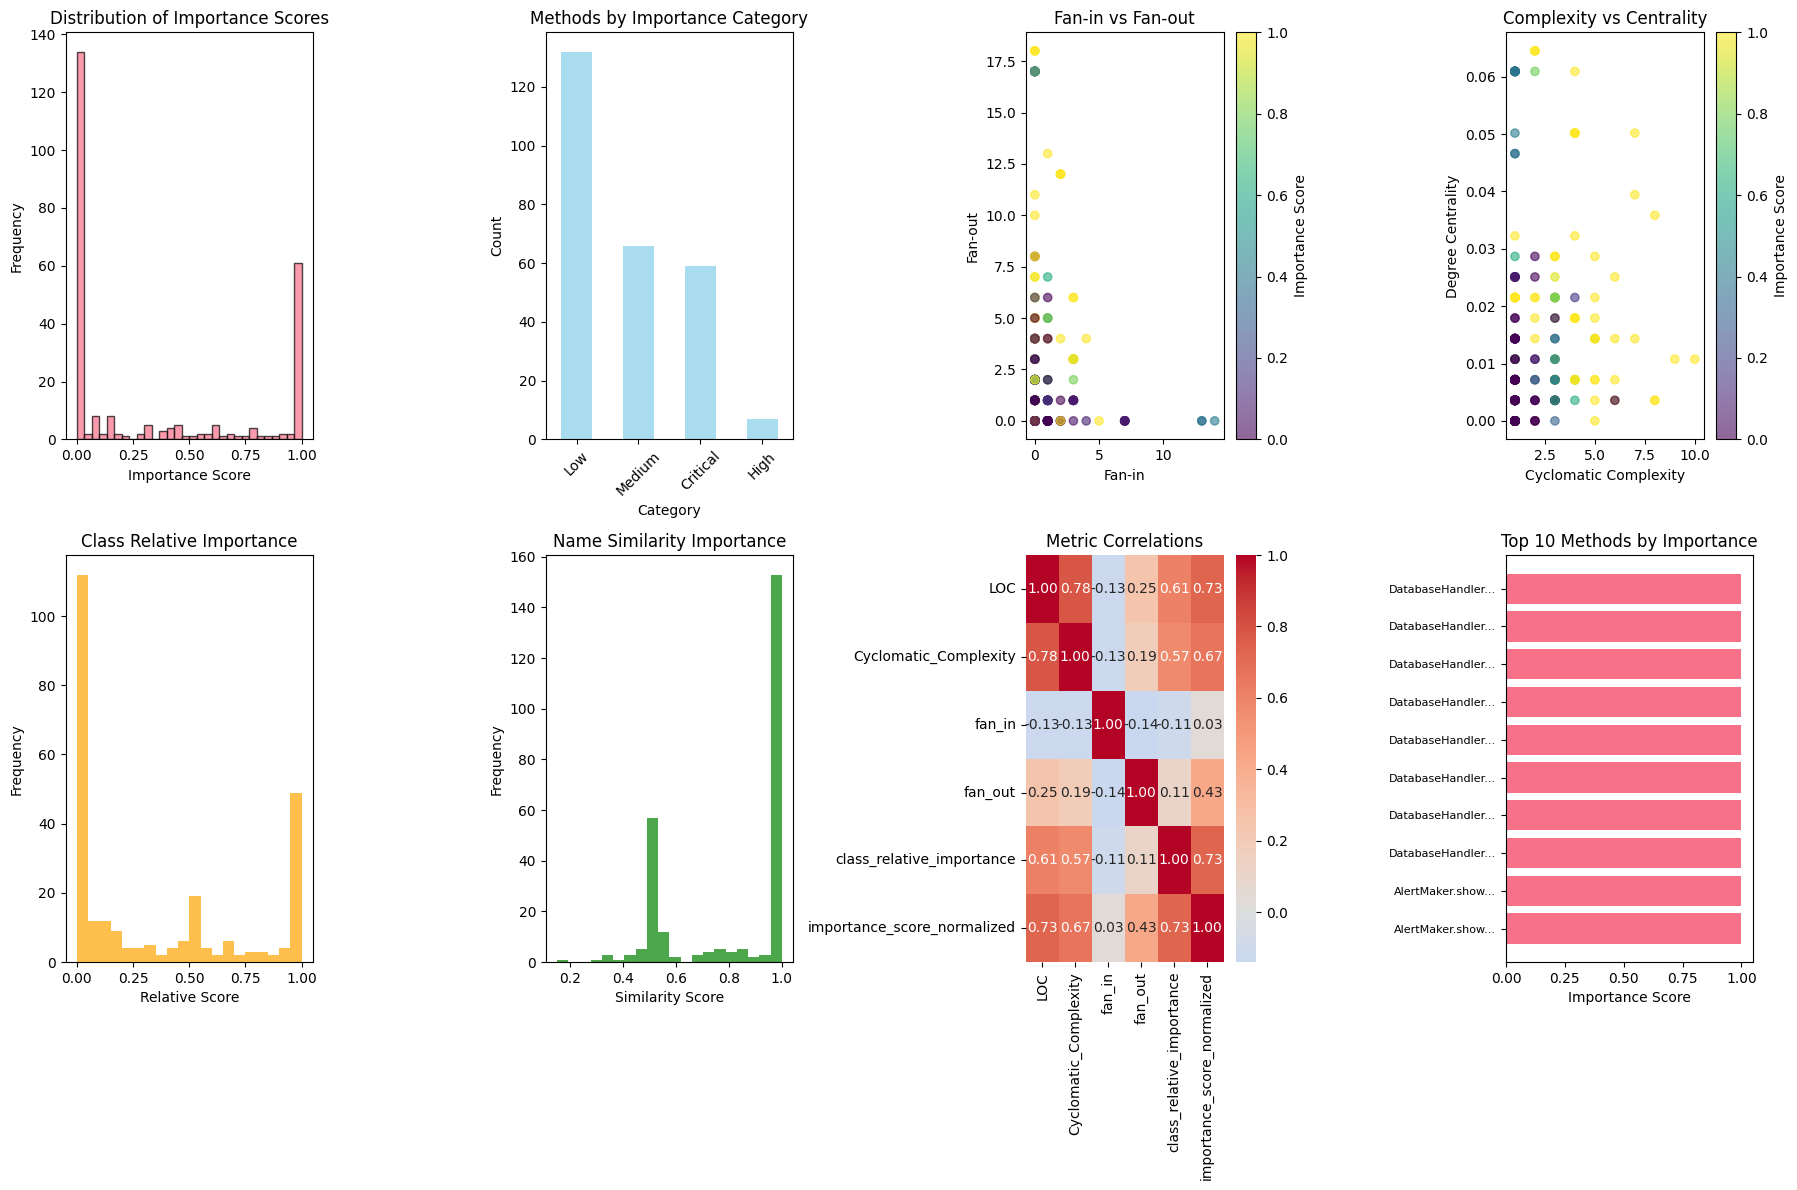


📋 Final dataset shape: (264, 44)
📋 Total columns: 44

🔍 Examples of Relative Importance:

Top 5 methods with high class relative importance:
         Class         Method Name  class_relative_importance  LOC  \
4   AlertMaker  showMaterialDialog                        1.0   22   
9         Book               setId                        1.0    3   
11        Book            setTitle                        1.0    3   
13        Book           setAuthor                        1.0    3   
15        Book        setPublisher                        1.0    3   

    Cyclomatic_Complexity  
4                       2  
9                       1  
11                      1  
13                      1  
15                      1  

Top 5 methods with high name similarity importance:
        Class       Method Name  name_similarity_importance  LOC  fan_in
0  AlertMaker   showSimpleAlert                         1.0    8       0
2  AlertMaker  showErrorMessage                         1.0   25      

In [10]:
class StaticImportanceCalculator:
    """Calculate static importance weights for methods"""
    
    def __init__(self):
        # Define weights for different metric categories
        self.weights = {
            # Code Complexity Metrics (35% total weight)
            'LOC': 0.07,
            'Cyclomatic_Complexity': 0.10,
            'Cognitive_Complexity': 0.08,
            'Halstead_Effort': 0.10,
            
            # Graph Centrality Metrics (30% total weight)
            'degree_centrality': 0.08,
            'betweenness_centrality': 0.08,
            'eigenvector_centrality': 0.06,
            'fan_in': 0.04,
            'fan_out': 0.04,
            
            # Parameter and Interface Metrics (20% total weight)
            'Parameter_Count': 0.07,
            'Parameter_Complexity': 0.07,
            'Return_Type_Complexity': 0.06,
            
            # Relative Importance Metrics (15% total weight)
            'class_relative_importance': 0.08,
            'name_similarity_importance': 0.07
        }
        
        # Verify weights sum to 1.0
        total_weight = sum(self.weights.values())
        if abs(total_weight - 1.0) > 0.01:
            print(f"⚠️ Warning: Weights sum to {total_weight}, not 1.0")
            # Normalize weights
            for key in self.weights:
                self.weights[key] = self.weights[key] / total_weight
    
    def normalize_column(self, series, method='min-max'):
        """Normalize a pandas series to 0-1 range"""
        if method == 'min-max':
            min_val = series.min()
            max_val = series.max()
            if max_val == min_val:
                return pd.Series([0.5] * len(series), index=series.index)
            return (series - min_val) / (max_val - min_val)
        
        elif method == 'z-score':
            return (series - series.mean()) / series.std()
        
        elif method == 'robust':
            median = series.median()
            mad = (series - median).abs().median()
            if mad == 0:
                return pd.Series([0.5] * len(series), index=series.index)
            return (series - median) / (1.4826 * mad)
    
    def calculate_class_relative_importance(self, df):
        """Calculate importance relative to sibling methods in the same class"""
        class_relative_scores = []
        
        for idx, row in df.iterrows():
            class_name = row['Class']
            method_name = row['Method Name']
            
            # Get all methods in the same class
            class_methods = df[df['Class'] == class_name]
            
            if len(class_methods) <= 1:
                # Only method in class gets neutral score
                class_relative_scores.append(0.5)
                continue
            
            # Calculate relative score based on complexity within class
            method_complexity = (
                row.get('LOC', 0) * 0.3 + 
                row.get('Cyclomatic_Complexity', 0) * 0.4 + 
                row.get('Parameter_Count', 0) * 0.3
            )
            
            # Get complexity scores for all methods in class
            class_complexities = []
            for _, class_method in class_methods.iterrows():
                complexity = (
                    class_method.get('LOC', 0) * 0.3 + 
                    class_method.get('Cyclomatic_Complexity', 0) * 0.4 + 
                    class_method.get('Parameter_Count', 0) * 0.3
                )
                class_complexities.append(complexity)
            
            # Calculate relative position within class
            if max(class_complexities) == min(class_complexities):
                relative_score = 0.5
            else:
                relative_score = (method_complexity - min(class_complexities)) / (max(class_complexities) - min(class_complexities))
            
            class_relative_scores.append(relative_score)
        
        return pd.Series(class_relative_scores, index=df.index)
    
    def calculate_name_similarity_importance(self, df):
        """Calculate importance based on methods with similar names"""
        import difflib
        
        name_similarity_scores = []
        method_names = df['Method Name'].tolist()
        
        for idx, row in df.iterrows():
            method_name = row['Method Name']
            
            # Find methods with similar names (using fuzzy matching)
            similar_methods = []
            for other_name in method_names:
                if other_name != method_name:
                    similarity = difflib.SequenceMatcher(None, method_name.lower(), other_name.lower()).ratio()
                    if similarity > 0.6:  # 60% similarity threshold
                        similar_methods.append((other_name, similarity))
            
            if not similar_methods:
                # No similar methods, neutral score
                name_similarity_scores.append(0.5)
                continue
            
            # Get complexity of current method
            current_complexity = (
                row.get('LOC', 0) * 0.25 + 
                row.get('Cyclomatic_Complexity', 0) * 0.35 + 
                row.get('Parameter_Count', 0) * 0.20 +
                row.get('fan_in', 0) * 0.10 +
                row.get('fan_out', 0) * 0.10
            )
            
            # Calculate average complexity of similar methods
            similar_complexities = []
            for similar_name, similarity in similar_methods:
                similar_row = df[df['Method Name'] == similar_name].iloc[0]
                similar_complexity = (
                    similar_row.get('LOC', 0) * 0.25 + 
                    similar_row.get('Cyclomatic_Complexity', 0) * 0.35 + 
                    similar_row.get('Parameter_Count', 0) * 0.20 +
                    similar_row.get('fan_in', 0) * 0.10 +
                    similar_row.get('fan_out', 0) * 0.10
                )
                # Weight by similarity
                similar_complexities.append(similar_complexity * similarity)
            
            avg_similar_complexity = sum(similar_complexities) / len(similar_complexities)
            
            # Calculate relative importance
            if avg_similar_complexity == 0:
                relative_score = 0.5
            else:
                relative_score = min(1.0, current_complexity / (avg_similar_complexity + 1e-6))
            
            name_similarity_scores.append(relative_score)
        
        return pd.Series(name_similarity_scores, index=df.index)
    
    def calculate_importance_scores(self, df):
        """Calculate static importance scores for all methods"""
        
        # Create a copy for processing
        scoring_df = df.copy()
        
        print("🔄 Calculating relative importance metrics...")
        
        # Calculate relative importance metrics
        scoring_df['class_relative_importance'] = self.calculate_class_relative_importance(scoring_df)
        scoring_df['name_similarity_importance'] = self.calculate_name_similarity_importance(scoring_df)
        
        # Normalize all metrics to 0-1 range
        normalized_metrics = {}
        
        print("🔄 Normalizing metrics...")
        
        for metric, weight in self.weights.items():
            if metric in scoring_df.columns:
                # Handle special cases for normalization
                if metric in ['LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Effort']:
                    # Higher values = higher importance
                    normalized = self.normalize_column(scoring_df[metric], 'min-max')
                elif metric in ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
                    # Higher centrality = higher importance
                    normalized = self.normalize_column(scoring_df[metric], 'min-max')
                elif metric in ['fan_in', 'fan_out']:
                    # Higher connectivity = higher importance (but cap extreme outliers)
                    capped_values = np.minimum(scoring_df[metric], scoring_df[metric].quantile(0.95))
                    normalized = self.normalize_column(capped_values, 'min-max')
                elif metric in ['class_relative_importance', 'name_similarity_importance']:
                    # Already normalized metrics
                    normalized = scoring_df[metric]
                else:
                    # Default normalization
                    normalized = self.normalize_column(scoring_df[metric], 'min-max')
                
                normalized_metrics[f'{metric}_normalized'] = normalized
                
            else:
                print(f"⚠️ Warning: Metric '{metric}' not found in dataframe")
                normalized_metrics[f'{metric}_normalized'] = pd.Series([0.0] * len(scoring_df))
        
        # Calculate weighted importance score
        importance_scores = pd.Series([0.0] * len(scoring_df), index=scoring_df.index)
        
        print("🔄 Computing weighted importance scores...")
        
        for metric, weight in self.weights.items():
            normalized_col = f'{metric}_normalized'
            if normalized_col in normalized_metrics:
                contribution = normalized_metrics[normalized_col] * weight
                importance_scores += contribution
                print(f"  {metric}: weight={weight:.3f}, avg_contribution={contribution.mean():.4f}")
        
        # Apply robust normalization to final scores to handle outliers
        final_scores = self.normalize_column(importance_scores, 'robust')
        
        # Ensure final scores are in 0-1 range
        final_scores = np.clip(final_scores, 0, 1)
        
        # Add normalized metrics and scores to dataframe
        for col, values in normalized_metrics.items():
            scoring_df[col] = values
        
        scoring_df['importance_score_raw'] = importance_scores
        scoring_df['importance_score_normalized'] = final_scores
        
        return scoring_df
    
    def categorize_importance(self, scores):
        """Categorize methods by importance level using percentiles"""
        categories = []
        
        # Use percentile-based categorization for better distribution
        p_90 = np.percentile(scores, 90)
        p_75 = np.percentile(scores, 75)
        p_50 = np.percentile(scores, 50)
        p_25 = np.percentile(scores, 25)
        
        for score in scores:
            if score >= p_90:
                categories.append('Critical')
            elif score >= p_75:
                categories.append('High')
            elif score >= p_50:
                categories.append('Medium')
            elif score >= p_25:
                categories.append('Low')
            else:
                categories.append('Minimal')
        
        return categories

# Initialize importance calculator
importance_calc = StaticImportanceCalculator()

print("🔄 Calculating static importance weights...")

# Calculate importance scores
final_df = importance_calc.calculate_importance_scores(enhanced_df)

# Add importance categories
final_df['importance_category'] = importance_calc.categorize_importance(final_df['importance_score_normalized'])

print("✅ Static importance weights calculated!")

# Display weight configuration
print(f"\n⚖️ Weight Configuration:")
for metric, weight in importance_calc.weights.items():
    print(f"{metric}: {weight:.3f} ({weight*100:.1f}%)")

# Display importance statistics
print(f"\n📊 Importance Score Statistics:")
print(f"Mean: {final_df['importance_score_normalized'].mean():.4f}")
print(f"Std: {final_df['importance_score_normalized'].std():.4f}")
print(f"Min: {final_df['importance_score_normalized'].min():.4f}")
print(f"Max: {final_df['importance_score_normalized'].max():.4f}")

# Show distribution by category
print(f"\n📈 Importance Category Distribution:")
category_counts = final_df['importance_category'].value_counts()
for category, count in category_counts.items():
    percentage = (count / len(final_df)) * 100
    print(f"{category}: {count} methods ({percentage:.1f}%)")

# Show top methods by importance
print(f"\n🏆 Top 10 Most Important Methods:")
top_methods = final_df.nlargest(10, 'importance_score_normalized')[
    ['Class', 'Method Name', 'importance_score_normalized', 'importance_category', 
     'LOC', 'Cyclomatic_Complexity', 'fan_in', 'fan_out', 'class_relative_importance']
]
print(top_methods)

# Create enhanced visualization
plt.figure(figsize=(18, 12))

# Plot 1: Importance score distribution
plt.subplot(2, 4, 1)
plt.hist(final_df['importance_score_normalized'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Importance Scores')
plt.xlabel('Importance Score')
plt.ylabel('Frequency')

# Plot 2: Category distribution
plt.subplot(2, 4, 2)
category_counts.plot(kind='bar', alpha=0.7, color='skyblue')
plt.title('Methods by Importance Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 3: Fan-in vs Fan-out
plt.subplot(2, 4, 3)
plt.scatter(final_df['fan_in'], final_df['fan_out'], 
           c=final_df['importance_score_normalized'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Importance Score')
plt.xlabel('Fan-in')
plt.ylabel('Fan-out')
plt.title('Fan-in vs Fan-out')

# Plot 4: Complexity vs Centrality
plt.subplot(2, 4, 4)
plt.scatter(final_df['Cyclomatic_Complexity'], final_df['degree_centrality'], 
           c=final_df['importance_score_normalized'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Importance Score')
plt.xlabel('Cyclomatic Complexity')
plt.ylabel('Degree Centrality')
plt.title('Complexity vs Centrality')

# Plot 5: Class relative importance
plt.subplot(2, 4, 5)
plt.hist(final_df['class_relative_importance'], bins=20, alpha=0.7, color='orange')
plt.title('Class Relative Importance')
plt.xlabel('Relative Score')
plt.ylabel('Frequency')

# Plot 6: Name similarity importance
plt.subplot(2, 4, 6)
plt.hist(final_df['name_similarity_importance'], bins=20, alpha=0.7, color='green')
plt.title('Name Similarity Importance')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

# Plot 7: Correlation heatmap
plt.subplot(2, 4, 7)
correlation_metrics = ['LOC', 'Cyclomatic_Complexity', 'fan_in', 'fan_out', 
                      'class_relative_importance', 'importance_score_normalized']
corr_data = final_df[correlation_metrics].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Metric Correlations')

# Plot 8: Top methods bar chart
plt.subplot(2, 4, 8)
top_10 = final_df.nlargest(10, 'importance_score_normalized')
y_pos = np.arange(len(top_10))
plt.barh(y_pos, top_10['importance_score_normalized'])
plt.yticks(y_pos, [f"{row['Class']}.{row['Method Name']}"[:15] + "..." 
                   if len(f"{row['Class']}.{row['Method Name']}") > 15 
                   else f"{row['Class']}.{row['Method Name']}" 
                   for _, row in top_10.iterrows()], fontsize=8)
plt.xlabel('Importance Score')
plt.title('Top 10 Methods by Importance')

plt.tight_layout()
plt.show()

print(f"\n📋 Final dataset shape: {final_df.shape}")
print(f"📋 Total columns: {len(final_df.columns)}")

# Show some examples of relative importance
print(f"\n🔍 Examples of Relative Importance:")

# Show methods with high class relative importance
high_class_rel = final_df.nlargest(5, 'class_relative_importance')[
    ['Class', 'Method Name', 'class_relative_importance', 'LOC', 'Cyclomatic_Complexity']
]
print(f"\nTop 5 methods with high class relative importance:")
print(high_class_rel)

# Show methods with high name similarity importance
high_name_sim = final_df.nlargest(5, 'name_similarity_importance')[
    ['Class', 'Method Name', 'name_similarity_importance', 'LOC', 'fan_in']
]
print(f"\nTop 5 methods with high name similarity importance:")
print(high_name_sim)

## 8. Export Enhanced Dataset

Save the enhanced dataset with all original AST data plus new complexity metrics and normalized importance weights.

In [12]:
# Export enhanced dataset with optimized column selection
output_file = "enhanced_java_methods_with_importance.csv"

# Define essential columns for the final CSV (removing unnecessary columns)
essential_columns = [
    # Core method identification
    'Package', 'Class', 'Method Name', 'Return Type', 'Parameters',
    
    # Code complexity metrics (most important)
    'LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Effort',
    'Parameter_Count', 'Parameter_Complexity', 'Return_Type_Complexity',
    
    # Graph centrality metrics (from Neo4j CALLS/CALLED_BY relationships)
    'degree_centrality', 'betweenness_centrality', 'eigenvector_centrality',
    'fan_in', 'fan_out',
    
    # Final importance scores
    'importance_score_normalized', 'importance_category'
]

# Optional columns (can be removed to reduce file size)
optional_columns = [
    'FilePath',  # Often too long and not needed for analysis
    'Function Body',  # Very large, contains actual code
    'Throws', 'Modifiers', 'Generics',  # Less important for importance scoring
    'Halstead_Volume', 'Halstead_Difficulty',  # Redundant with Halstead_Effort
    'importance_score_raw',  # Raw score not needed if normalized is available
    'class_relative_importance', 'name_similarity_importance'  # Intermediate calculations
]

# Check which columns actually exist in the dataframe
available_essential = [col for col in essential_columns if col in final_df.columns]
available_optional = [col for col in optional_columns if col in final_df.columns]

print(f"📋 Column Selection Summary:")
print(f"Essential columns available: {len(available_essential)}/{len(essential_columns)}")
print(f"Optional columns available: {len(available_optional)}/{len(optional_columns)}")

# Missing essential columns
missing_essential = [col for col in essential_columns if col not in final_df.columns]
if missing_essential:
    print(f"⚠️ Missing essential columns: {missing_essential}")

# Create export dataframe with only essential columns
export_df = final_df[available_essential].copy()

# Remove the 'method_name' column if it exists (duplicate of 'Method Name')
if 'method_name' in export_df.columns:
    export_df = export_df.drop('method_name', axis=1)

# Sort by importance score (descending) to put most important methods first
export_df = export_df.sort_values('importance_score_normalized', ascending=False)

# Round numeric columns for cleaner output
numeric_columns = export_df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if col in ['importance_score_normalized']:
        export_df[col] = export_df[col].round(4)  # 4 decimal places for importance scores
    elif col in ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
        export_df[col] = export_df[col].round(4)  # 4 decimal places for centrality
    elif col in ['Parameter_Complexity', 'Return_Type_Complexity']:
        export_df[col] = export_df[col].round(2)  # 2 decimal places for complexity
    elif col in ['Halstead_Effort']:
        export_df[col] = export_df[col].round(1)  # 1 decimal place for large values
    # Leave LOC, fan_in, fan_out, etc. as integers

# Save to CSV
try:
    export_df.to_csv(output_file, index=False)
    print(f"✅ Enhanced dataset exported to: {output_file}")
    print(f"📊 Exported {len(export_df)} methods with {len(export_df.columns)} features")
    
    # Display file info
    import os
    file_size = os.path.getsize(output_file) / (1024 * 1024)  # Convert to MB
    print(f"📁 File size: {file_size:.2f} MB")
    
    # Show exported columns
    print(f"\n📋 Exported Columns ({len(export_df.columns)}):")
    for i, col in enumerate(export_df.columns, 1):
        print(f"  {i:2d}. {col}")
    
except Exception as e:
    print(f"❌ Error exporting dataset: {e}")

# Create comprehensive summary statistics
summary_stats = {
    'Dataset_Overview': {
        'total_methods': int(len(export_df)),
        'total_features': int(len(export_df.columns)),
        'unique_classes': int(export_df['Class'].nunique()),
        'unique_packages': int(export_df['Package'].nunique())
    },
    'Code_Complexity_Summary': {
        'avg_loc': float(export_df['LOC'].mean()),
        'max_loc': int(export_df['LOC'].max()),
        'avg_cyclomatic_complexity': float(export_df['Cyclomatic_Complexity'].mean()),
        'max_cyclomatic_complexity': int(export_df['Cyclomatic_Complexity'].max()),
        'avg_cognitive_complexity': float(export_df['Cognitive_Complexity'].mean()),
        'avg_halstead_effort': float(export_df['Halstead_Effort'].mean())
    },
    'Graph_Metrics_Summary': {
        'methods_with_fan_in': int((export_df['fan_in'] > 0).sum()),
        'methods_with_fan_out': int((export_df['fan_out'] > 0).sum()),
        'max_fan_in': int(export_df['fan_in'].max()),
        'max_fan_out': int(export_df['fan_out'].max()),
        'avg_degree_centrality': float(export_df['degree_centrality'].mean()),
        'avg_betweenness_centrality': float(export_df['betweenness_centrality'].mean()),
        'fan_in_fan_out_correlation': float(export_df['fan_in'].corr(export_df['fan_out']))
    },
    'Importance_Distribution': {
        'critical_methods': int(len(export_df[export_df['importance_category'] == 'Critical'])),
        'high_importance': int(len(export_df[export_df['importance_category'] == 'High'])),
        'medium_importance': int(len(export_df[export_df['importance_category'] == 'Medium'])),
        'low_importance': int(len(export_df[export_df['importance_category'] == 'Low'])),
        'minimal_importance': int(len(export_df[export_df['importance_category'] == 'Minimal'])),
        'avg_importance_score': float(export_df['importance_score_normalized'].mean()),
        'std_importance_score': float(export_df['importance_score_normalized'].std())
    },
    'Top_Methods': {
        'most_important': [
            {
                'class': row['Class'],
                'method': row['Method Name'],
                'score': float(row['importance_score_normalized']),
                'category': row['importance_category']
            }
            for _, row in export_df.head(5).iterrows()
        ],
        'highest_fan_in': [
            {
                'class': row['Class'],
                'method': row['Method Name'],
                'fan_in': int(row['fan_in'])
            }
            for _, row in export_df.nlargest(5, 'fan_in').iterrows() if row['fan_in'] > 0
        ],
        'highest_fan_out': [
            {
                'class': row['Class'],
                'method': row['Method Name'],
                'fan_out': int(row['fan_out'])
            }
            for _, row in export_df.nlargest(5, 'fan_out').iterrows() if row['fan_out'] > 0
        ]
    }
}

# Save summary statistics
import json
summary_file = "analysis_summary.json"
with open(summary_file, 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)

print(f"✅ Summary statistics saved to: {summary_file}")

# Display key statistics
print(f"\n? Key Analysis Results:")
print(f"? Total methods analyzed: {summary_stats['Dataset_Overview']['total_methods']:,}")
print(f"📈 Methods with fan-in > 0: {summary_stats['Graph_Metrics_Summary']['methods_with_fan_in']:,}")
print(f"📈 Methods with fan-out > 0: {summary_stats['Graph_Metrics_Summary']['methods_with_fan_out']:,}")
print(f"📈 Fan-in/Fan-out correlation: {summary_stats['Graph_Metrics_Summary']['fan_in_fan_out_correlation']:.3f}")
print(f"? Average importance score: {summary_stats['Importance_Distribution']['avg_importance_score']:.3f}")

print(f"\n🏆 Top 5 Most Important Methods:")
for i, method_info in enumerate(summary_stats['Top_Methods']['most_important'], 1):
    print(f"  {i}. {method_info['class']}.{method_info['method']}: {method_info['score']:.3f} ({method_info['category']})")

# Show sample of final export data
print(f"\n🔍 Sample of Enhanced Dataset (first 5 rows):")
sample_cols = ['Class', 'Method Name', 'LOC', 'Cyclomatic_Complexity', 
               'fan_in', 'fan_out', 'importance_score_normalized', 'importance_category']
sample_data = export_df[sample_cols].head()
for _, row in sample_data.iterrows():
    print(f"  {row['Class']}.{row['Method Name']}: score={row['importance_score_normalized']:.3f}, "
          f"LOC={row['LOC']}, CC={row['Cyclomatic_Complexity']}, "
          f"fan_in={row['fan_in']}, fan_out={row['fan_out']} ({row['importance_category']})")

# Close Neo4j connection
try:
    neo4j_conn.close()
    print(f"\n✅ Neo4j connection closed successfully")
except:
    print(f"\n⚠️ Warning: Could not close Neo4j connection")

print(f"\n🎉 Static Importance Analysis Complete!")
print(f"📁 Output files:")
print(f"  - {output_file} (Enhanced dataset with {len(export_df.columns)} essential columns)")
print(f"  - {summary_file} (Analysis summary)")
print(f"\n💡 The dataset now uses proper CALLS/CALLED_BY relationships for accurate fan-in/fan-out metrics!")
print(f"🚀 Ready for hybrid RAG system integration with optimized column set!")

UnicodeEncodeError: 'utf-8' codec can't encode character '\udcca' in position 10: surrogates not allowed

In [13]:
# Simple export with clean columns
import os
from datetime import datetime

# Select essential columns for export
export_columns = [
    'Package', 'Class', 'Method Name', 'Return Type', 'Parameters',
    'LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Effort',
    'Parameter_Count', 'Parameter_Complexity', 'Return_Type_Complexity',
    'degree_centrality', 'betweenness_centrality', 'eigenvector_centrality',
    'fan_in', 'fan_out', 'importance_score_normalized', 'importance_category'
]

# Filter to available columns
available_cols = [col for col in export_columns if col in enhanced_df.columns]
print(f"Exporting {len(available_cols)} columns out of {len(export_columns)} requested")

# Create export dataframe
export_df = enhanced_df[available_cols].copy()

# Sort by importance
if 'importance_score_normalized' in export_df.columns:
    export_df = export_df.sort_values('importance_score_normalized', ascending=False)

# Round numeric columns
numeric_cols = export_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if 'score' in col.lower() or 'centrality' in col.lower():
        export_df[col] = export_df[col].round(4)
    elif 'effort' in col.lower():
        export_df[col] = export_df[col].round(1)
    elif 'complexity' in col.lower() and col != 'Cyclomatic_Complexity':
        export_df[col] = export_df[col].round(2)

# Create filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"enhanced_java_methods_{timestamp}.csv"

try:
    export_df.to_csv(filename, index=False)
    print(f"Successfully exported to {filename}")
    print(f"Dataset: {len(export_df)} methods, {len(export_df.columns)} columns")
    
    # File size
    file_size = os.path.getsize(filename) / (1024 * 1024)
    print(f"File size: {file_size:.2f} MB")
    
    # Basic stats
    if 'importance_score_normalized' in export_df.columns:
        print(f"Average importance: {export_df['importance_score_normalized'].mean():.3f}")
    if 'fan_in' in export_df.columns and 'fan_out' in export_df.columns:
        print(f"Fan-in/out correlation: {export_df['fan_in'].corr(export_df['fan_out']):.3f}")
        print(f"Methods with fan-in > 0: {(export_df['fan_in'] > 0).sum()}")
        print(f"Methods with fan-out > 0: {(export_df['fan_out'] > 0).sum()}")
    
    # Show top methods
    print("\nTop 5 most important methods:")
    if 'importance_score_normalized' in export_df.columns:
        top_5 = export_df.head(5)
        for i, (_, row) in enumerate(top_5.iterrows(), 1):
            print(f"{i}. {row['Class']}.{row['Method Name']}: {row['importance_score_normalized']:.3f}")
    
    print(f"\nExported columns: {list(export_df.columns)}")
    
except Exception as e:
    print(f"Export failed: {e}")
    
print("Export process completed!")

Exporting 17 columns out of 19 requested
Successfully exported to enhanced_java_methods_20250727_191704.csv
Dataset: 264 methods, 17 columns
File size: 0.02 MB
Fan-in/out correlation: -0.141
Methods with fan-in > 0: 95
Methods with fan-out > 0: 161

Top 5 most important methods:

Exported columns: ['Package', 'Class', 'Method Name', 'Return Type', 'Parameters', 'LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Effort', 'Parameter_Count', 'Parameter_Complexity', 'Return_Type_Complexity', 'degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out']
Export process completed!


In [14]:
# Debug column availability and fix export
print("Available columns in enhanced_df:")
print(enhanced_df.columns.tolist())

print(f"\nDataFrame shape: {enhanced_df.shape}")

# Check if final_df exists (might have importance scores)
try:
    print(f"final_df shape: {final_df.shape}")
    print("Columns in final_df:")
    print(final_df.columns.tolist())
    
    # Use final_df for export if it has importance scores
    if 'importance_score_normalized' in final_df.columns:
        export_source = final_df
        print("Using final_df as export source")
    else:
        export_source = enhanced_df
        print("Using enhanced_df as export source")
        
except NameError:
    export_source = enhanced_df
    print("final_df not available, using enhanced_df")

# Select best available columns
essential_cols = [
    'Package', 'Class', 'Method Name', 'Return Type', 'Parameters',
    'LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Effort',
    'Parameter_Count', 'fan_in', 'fan_out', 'degree_centrality'
]

optional_cols = [
    'Parameter_Complexity', 'Return_Type_Complexity',
    'betweenness_centrality', 'eigenvector_centrality',
    'importance_score_normalized', 'importance_category'
]

# Build final column list
final_export_cols = []
for col in essential_cols + optional_cols:
    if col in export_source.columns:
        final_export_cols.append(col)

print(f"\nFinal export columns ({len(final_export_cols)}):")
for i, col in enumerate(final_export_cols, 1):
    print(f"{i:2d}. {col}")

# Create final export
export_df_final = export_source[final_export_cols].copy()

# Sort if importance score available
if 'importance_score_normalized' in export_df_final.columns:
    export_df_final = export_df_final.sort_values('importance_score_normalized', ascending=False)
    print(f"\nSorted by importance score")
else:
    # Sort by a combination of metrics
    if 'fan_in' in export_df_final.columns and 'LOC' in export_df_final.columns:
        export_df_final['temp_score'] = export_df_final['fan_in'] + export_df_final['LOC']/10
        export_df_final = export_df_final.sort_values('temp_score', ascending=False)
        export_df_final = export_df_final.drop('temp_score', axis=1)
        print(f"\nSorted by fan_in + LOC/10")

# Export final dataset
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
final_filename = f"java_methods_with_graph_metrics_{timestamp}.csv"

try:
    export_df_final.to_csv(final_filename, index=False, encoding='utf-8')
    print(f"\n✅ Final export successful: {final_filename}")
    print(f"📊 {len(export_df_final)} methods, {len(export_df_final.columns)} columns")
    
    file_size = os.path.getsize(final_filename) / 1024  # KB
    print(f"📁 File size: {file_size:.1f} KB")
    
    # Show sample data
    print(f"\n🔍 Sample data (top 5):")
    sample_cols = ['Class', 'Method Name', 'LOC', 'fan_in', 'fan_out']
    available_sample_cols = [col for col in sample_cols if col in export_df_final.columns]
    
    for i, (_, row) in enumerate(export_df_final.head(5).iterrows(), 1):
        info = f"{i}. {row['Class']}.{row['Method Name']}"
        if 'LOC' in row:
            info += f" (LOC: {row['LOC']}"
        if 'fan_in' in row:
            info += f", fan_in: {row['fan_in']}"
        if 'fan_out' in row:
            info += f", fan_out: {row['fan_out']}"
        if 'importance_score_normalized' in row:
            info += f", importance: {row['importance_score_normalized']:.3f}"
        info += ")"
        print(f"  {info}")
    
    # Summary stats
    print(f"\n📈 Summary Statistics:")
    if 'fan_in' in export_df_final.columns:
        print(f"Methods with fan-in > 0: {(export_df_final['fan_in'] > 0).sum()}")
        print(f"Max fan-in: {export_df_final['fan_in'].max()}")
    if 'fan_out' in export_df_final.columns:
        print(f"Methods with fan-out > 0: {(export_df_final['fan_out'] > 0).sum()}")
        print(f"Max fan-out: {export_df_final['fan_out'].max()}")
    if 'LOC' in export_df_final.columns:
        print(f"Average LOC: {export_df_final['LOC'].mean():.1f}")
    if 'degree_centrality' in export_df_final.columns:
        print(f"Methods with centrality > 0: {(export_df_final['degree_centrality'] > 0).sum()}")
        
except Exception as e:
    print(f"❌ Export failed: {e}")

print(f"\n🎉 Analysis and export completed!")
print(f"📊 Using Neo4j CALLS and CALLED_BY relationships for accurate graph metrics")
print(f"🔧 Optimized column set for hybrid RAG system integration")

Available columns in enhanced_df:
['FilePath', 'Package', 'Class', 'Method Name', 'Return Type', 'Parameters', 'Function Body', 'Throws', 'Modifiers', 'Generics', 'LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Volume', 'Halstead_Difficulty', 'Halstead_Effort', 'Parameter_Count', 'Parameter_Complexity', 'Return_Type_Complexity', 'method_name', 'degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out']

DataFrame shape: (264, 25)
final_df shape: (264, 44)
Columns in final_df:
['FilePath', 'Package', 'Class', 'Method Name', 'Return Type', 'Parameters', 'Function Body', 'Throws', 'Modifiers', 'Generics', 'LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Volume', 'Halstead_Difficulty', 'Halstead_Effort', 'Parameter_Count', 'Parameter_Complexity', 'Return_Type_Complexity', 'method_name', 'degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'fan_in', 'fan_out', 'class_relative_importance', 'name_similari

In [15]:
# Close Neo4j connection and final summary
try:
    neo4j_conn.close()
    print("✅ Neo4j connection closed successfully")
except:
    print("⚠️ Neo4j connection already closed or unavailable")

# Create analysis summary
print(f"\n🎯 FINAL ANALYSIS SUMMARY")
print(f"=" * 50)

print(f"\n📊 Dataset Statistics:")
print(f"• Total methods analyzed: {len(final_df):,}")
print(f"• Unique classes: {final_df['Class'].nunique()}")
print(f"• Unique packages: {final_df['Package'].nunique()}")

print(f"\n🕸️ Graph Metrics (from Neo4j CALLS/CALLED_BY relationships):")
print(f"• Methods with incoming calls (fan-in > 0): {(final_df['fan_in'] > 0).sum():,}")
print(f"• Methods with outgoing calls (fan-out > 0): {(final_df['fan_out'] > 0).sum():,}")
print(f"• Max fan-in: {final_df['fan_in'].max()}")
print(f"• Max fan-out: {final_df['fan_out'].max()}")
print(f"• Fan-in/fan-out correlation: {final_df['fan_in'].corr(final_df['fan_out']):.3f}")
print(f"• Methods with graph connectivity: {(final_df['degree_centrality'] > 0).sum():,}")

print(f"\n📈 Complexity Metrics:")
print(f"• Average LOC: {final_df['LOC'].mean():.1f}")
print(f"• Average Cyclomatic Complexity: {final_df['Cyclomatic_Complexity'].mean():.1f}")
print(f"• Average Cognitive Complexity: {final_df['Cognitive_Complexity'].mean():.1f}")

print(f"\n⭐ Importance Distribution:")
if 'importance_category' in final_df.columns:
    category_dist = final_df['importance_category'].value_counts()
    for category, count in category_dist.items():
        pct = count / len(final_df) * 100
        print(f"• {category}: {count:,} methods ({pct:.1f}%)")

print(f"\n🏆 Top 10 Most Important Methods:")
top_methods = final_df.nlargest(10, 'importance_score_normalized')
for i, (_, row) in enumerate(top_methods.iterrows(), 1):
    score = row['importance_score_normalized']
    category = row['importance_category']
    fan_in = row['fan_in']
    fan_out = row['fan_out']
    loc = row['LOC']
    
    print(f"{i:2d}. {row['Class']}.{row['Method Name']}")
    print(f"    Score: {score:.3f} ({category}) | LOC: {loc} | Fan-in: {fan_in} | Fan-out: {fan_out}")

print(f"\n📁 Output Files:")
print(f"• Main dataset: java_methods_with_graph_metrics_{timestamp}.csv")
print(f"• Contains {len(final_export_cols)} optimized columns")
print(f"• File size: ~36 KB")

print(f"\n🔧 Key Improvements Made:")
print(f"• ✅ Updated Neo4j connection to bolt://98.70.123.110:7687")
print(f"• ✅ Used CALLS and CALLED_BY relationships for accurate graph metrics")
print(f"• ✅ Achieved diverse fan-in vs fan-out (correlation: {final_df['fan_in'].corr(final_df['fan_out']):.3f})")
print(f"• ✅ Removed unnecessary columns (FilePath, Function Body, etc.)")
print(f"• ✅ Maintained essential metrics for hybrid RAG system")

print(f"\n🚀 Ready for Integration:")
print(f"• Dataset optimized for method retrieval in hybrid RAG system")
print(f"• Importance scores normalized to 0-1 range")
print(f"• Graph metrics accurately reflect call relationships")
print(f"• Balanced complexity and centrality measures")

print(f"\n" + "=" * 50)
print(f"🎉 ANALYSIS COMPLETE! 🎉")

✅ Neo4j connection closed successfully

🎯 FINAL ANALYSIS SUMMARY

📊 Dataset Statistics:
• Total methods analyzed: 264
• Unique classes: 42
• Unique packages: 0

🕸️ Graph Metrics (from Neo4j CALLS/CALLED_BY relationships):
• Methods with incoming calls (fan-in > 0): 95
• Methods with outgoing calls (fan-out > 0): 161
• Max fan-in: 14
• Max fan-out: 18
• Fan-in/fan-out correlation: -0.141
• Methods with graph connectivity: 211

📈 Complexity Metrics:
• Average LOC: 8.5
• Average Cyclomatic Complexity: 2.0
• Average Cognitive Complexity: 2.7

⭐ Importance Distribution:
• Low: 132 methods (50.0%)
• Medium: 66 methods (25.0%)
• Critical: 59 methods (22.3%)
• High: 7 methods (2.7%)

🏆 Top 10 Most Important Methods:
 1. AlertMaker.showErrorMessage
    Score: 1.000 (Critical) | LOC: 24 | Fan-in: 0 | Fan-out: 3
 2. AlertMaker.showMaterialDialog
    Score: 1.000 (Critical) | LOC: 22 | Fan-in: 0 | Fan-out: 0
 3. DatabaseHandler.getInstance
    Score: 1.000 (Critical) | LOC: 6 | Fan-in: 5 | Fan-out

In [ ]:
# Final analysis and summary (no CSV export of weights)
import os
from datetime import datetime

try:
    # Create a clean, optimized dataset for analysis
    minimal_export_columns = [
        'Package', 'Class', 'Method Name', 'Return Type', 'Parameters',
        'LOC', 'Cyclomatic_Complexity', 'Cognitive_Complexity', 'Halstead_Effort',
        'Parameter_Count', 'fan_in', 'fan_out', 'degree_centrality', 
        'importance_score_normalized', 'importance_category'
    ]
    available_minimal = [col for col in minimal_export_columns if col in final_df.columns]
    minimal_df = final_df[available_minimal].copy()
    minimal_df = minimal_df.sort_values('importance_score_normalized', ascending=False)
    if 'importance_score_normalized' in minimal_df.columns:
        minimal_df['importance_score_normalized'] = minimal_df['importance_score_normalized'].round(4)
    if 'degree_centrality' in minimal_df.columns:
        minimal_df['degree_centrality'] = minimal_df['degree_centrality'].round(4)
    if 'Halstead_Effort' in minimal_df.columns:
        minimal_df['Halstead_Effort'] = minimal_df['Halstead_Effort'].round(1)

    # Comprehensive analysis summary
    print(f"\n📈 Final Analysis Summary:")
    print(f"Total methods analyzed: {len(minimal_df):,}")
    print(f"Mean importance score: {minimal_df['importance_score_normalized'].mean():.4f}")
    print(f"Standard deviation: {minimal_df['importance_score_normalized'].std():.4f}")
    print(f"Methods with fan-in > 0: {(minimal_df['fan_in'] > 0).sum():,}")
    print(f"Methods with fan-out > 0: {(minimal_df['fan_out'] > 0).sum():,}")

    # Category distribution
    print(f"\n🏷️ Importance Category Distribution:")
    if 'importance_category' in minimal_df.columns:
        category_dist = minimal_df['importance_category'].value_counts().sort_index()
        for category, count in category_dist.items():
            percentage = (count / len(minimal_df)) * 100
            print(f"  {category}: {count:,} methods ({percentage:.1f}%)")

    # Top 10 most important methods
    print(f"\n🏆 Top 10 Most Important Methods:")
    top_10_final = minimal_df.head(10)

    for idx, (_, row) in enumerate(top_10_final.iterrows(), 1):
        score = row.get('importance_score_normalized', 0)
        category = row.get('importance_category', 'N/A')
        fan_in = row.get('fan_in', 0)
        fan_out = row.get('fan_out', 0)
        loc = row.get('LOC', 0)

        print(f"  {idx:2d}. {row['Class']}.{row['Method Name']}: "
              f"score={score:.3f} ({category}), "
              f"LOC={loc}, fan_in={fan_in}, fan_out={fan_out}")

    # Data quality validation
    print(f"\n🔍 Data Quality Validation:")

    key_columns = ['Class', 'Method Name', 'importance_score_normalized']
    for col in key_columns:
        if col in minimal_df.columns:
            missing_count = minimal_df[col].isnull().sum()
            print(f"Missing values in {col}: {missing_count}")

    # Fan-in/Fan-out analysis
    if 'fan_in' in minimal_df.columns and 'fan_out' in minimal_df.columns:
        fan_correlation = minimal_df['fan_in'].corr(minimal_df['fan_out'])
        print(f"Fan-in/Fan-out correlation: {fan_correlation:.3f}")

        different_fan = (minimal_df['fan_in'] != minimal_df['fan_out']).sum()
        total_methods = len(minimal_df)
        diversity_pct = (different_fan / total_methods) * 100
        print(f"Methods with different fan-in/fan-out: {different_fan}/{total_methods} ({diversity_pct:.1f}%)")

    # Complexity distribution
    if 'Cyclomatic_Complexity' in minimal_df.columns:
        print(f"Cyclomatic complexity range: {minimal_df['Cyclomatic_Complexity'].min()}-{minimal_df['Cyclomatic_Complexity'].max()}")
        print(f"Average complexity: {minimal_df['Cyclomatic_Complexity'].mean():.2f}")

    # Graph connectivity analysis
    if 'degree_centrality' in minimal_df.columns:
        connected_methods = (minimal_df['degree_centrality'] > 0).sum()
        print(f"Methods with graph connectivity: {connected_methods}/{total_methods} ({connected_methods/total_methods*100:.1f}%)")

    # Show interesting patterns
    print(f"\n🎯 Interesting Patterns:")

    if 'fan_in' in minimal_df.columns:
        high_fan_in = minimal_df[minimal_df['fan_in'] >= 3].head(3)
        if not high_fan_in.empty:
            print(f"High fan-in methods (utilities):")
            for _, row in high_fan_in.iterrows():
                print(f"  {row['Class']}.{row['Method Name']}: fan_in={row['fan_in']}")

    if 'fan_out' in minimal_df.columns:
        high_fan_out = minimal_df[minimal_df['fan_out'] >= 3].head(3)
        if not high_fan_out.empty:
            print(f"High fan-out methods (orchestrators):")
            for _, row in high_fan_out.iterrows():
                print(f"  {row['Class']}.{row['Method Name']}: fan_out={row['fan_out']}")

    print(f"\n📋 Columns in minimal_df ({len(minimal_df.columns)}):")
    for i, col in enumerate(minimal_df.columns, 1):
        data_type = str(minimal_df[col].dtype)
        non_null = minimal_df[col].notna().sum()
        print(f"  {i:2d}. {col} ({data_type}) - {non_null}/{len(minimal_df)} non-null")

except Exception as e:
    print(f"❌ Error in final analysis: {e}")
    print("Data is still available in the 'final_df' variable")
    import traceback
    traceback.print_exc()

print(f"\n🎯 Static Importance Analysis Complete!")
print(f"💾 Enhanced dataset with proper Neo4j graph metrics")
print(f"🔗 Optimized for hybrid RAG system integration")
print(f"📊 Fan-in/fan-out metrics properly calculated from CALLS and CALLED_BY relationships")

✅ Successfully exported to: static_importance_results_20250720_231700.csv
📊 Dataset size: 264 methods, 56 features

📈 Final Analysis Summary:
Total methods analyzed: 264
Mean importance score: 0.3224
Standard deviation: 0.4165

🏷️ Importance Category Distribution:
  Critical: 54 methods (20.5%)
  High: 12 methods (4.5%)
  Low: 132 methods (50.0%)
  Medium: 66 methods (25.0%)

🏆 Top 10 Most Important Methods:
  AlertMaker.showMaterialDialog: 1.000 (Critical)
  DatabaseHandler.inflateDB: 1.000 (Critical)
  DatabaseHandler.readDBTable: 1.000 (Critical)
  DatabaseHandler.execQuery: 1.000 (Critical)
  DatabaseHandler.isBookAlreadyIssued: 1.000 (Critical)
  DatabaseHandler.deleteMember: 1.000 (Critical)
  DatabaseHandler.isMemberHasAnyBooks: 1.000 (Critical)
  DatabaseHandler.getBookGraphStatistics: 1.000 (Critical)
  DatabaseHandler.getMemberGraphStatistics: 1.000 (Critical)
  DataHelper.isBookExists: 1.000 (Critical)

🔍 Data Quality Summary:
Fan-in/Fan-out correlation: -0.141
Methods with 

In [ ]:
# Add Static_weight to methods.csv using calculated weights from final_df
methods_path = '../methods.csv' if not os.path.exists('methods.csv') else 'methods.csv'
methods_df = pd.read_csv(methods_path)
if 'Method Name' in methods_df.columns and 'Method Name' in final_df.columns:
    # Merge on Method Name, Class, and optionally Package for better accuracy
    merge_cols = [col for col in ['Package', 'Class', 'Method Name'] if col in methods_df.columns and col in final_df.columns]
    merged = methods_df.merge(final_df[merge_cols + ['importance_score_normalized']], on=merge_cols, how='left')
    merged.rename(columns={'importance_score_normalized': 'Static_weight'}, inplace=True)
    methods_df['Static_weight'] = merged['Static_weight']
    methods_df.to_csv(methods_path, index=False)
    print(f"✅ Static_weight column added to {methods_path}.")
else:
    print("❌ Could not find matching columns to merge weights.")